# AEBS - AOBxFAC_2F product - long term teporal development

Demonstration of `AOBxFAC_2F` product.

Feel free to change the `SPACECRAFT`, `START_TIME`, and `END_TIME` paramteres and re-run the notebook.

The notebook retrieves and displays data for the selected satellite and time range.

In [1]:
#------------------------------------------------------------------------------
# User input:

SPACECRAFT = 'A'
START_TIME='2015-05-01T00:00:00Z'
END_TIME='2015-07-31T00:00:00Z'

SERVER_URL = 'https://staging.viresdisc.vires.services/ows'

#------------------------------------------------------------------------------

from viresclient import SwarmRequest

PI_START = +1
PI_STOP = -1


SwarmRequest.COLLECTIONS.update({
    'AOB_FAC': ['SW_OPER_AOB{}FAC_2F'.format(x) for x in 'ABC'],
})

SwarmRequest.PRODUCT_VARIABLES.update({
    'AOB_FAC': [
        'Latitude_QD', 'Longitude_QD', 'MLT_QD',
        'Boundary_Flag', 'Quality', 'Pair_Indicator'
    ],
})

try:
    request = SwarmRequest(SERVER_URL)

    request.set_collection('SW_OPER_AOB%sFAC_2F' % SPACECRAFT)
    request.set_products(
        measurements=[
            'Latitude_QD', 'Longitude_QD', 'MLT_QD', 'Boundary_Flag',
            'Quality', 'Pair_Indicator',
        ],
        auxiliaries=['QDOrbitDirection', 'OrbitNumber', 'Kp'],
    )

    response = request.get_between(
        start_time=START_TIME,
        end_time=END_TIME,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    boundaries = response.as_xarray()

except Exception as error:
    print('ERROR: ', error)
else:
    print(boundaries)

[1/2] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.485MB)
[2/2] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.414MB)


Sources:
	SW_OPER_AOBAFAC_2F_20150101T000000_20151231T235959_0102
	SW_OPER_AUXAORBCNT_20131122T000000_20200625T000000_0001
	SW_OPER_AUX_KP__2__19980101T013000_20200625T043000_0001
	SW_OPER_MAGA_LR_1B_20150501T000000_20150501T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150502T000000_20150502T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150503T000000_20150503T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150504T000000_20150504T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150505T000000_20150505T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150506T000000_20150506T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150507T000000_20150507T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150508T000000_20150508T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150509T000000_20150509T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150510T000000_20150510T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150511T000000_20150511T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150512T000000_20150512T235959_0505_MDR_MAG_LR
	SW_

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


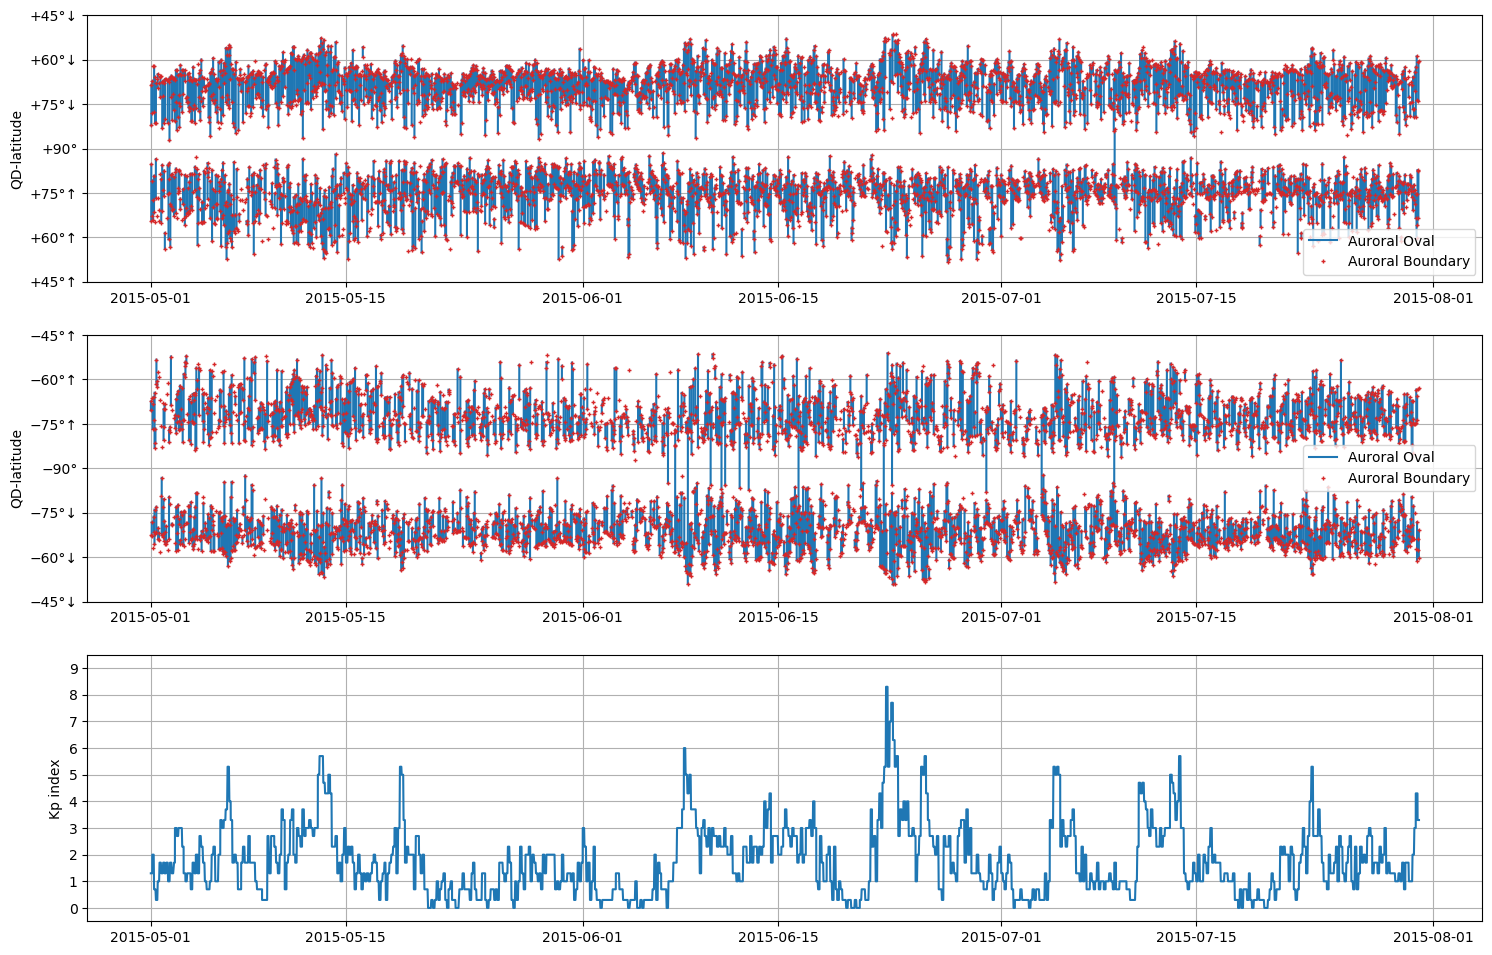

In [2]:
from numpy import stack
from matplotlib.pyplot import figure, subplot, show
%matplotlib inline


def _orbit_lat(latitude, orbit_direction):
    orbit_latitude = latitude.copy()
    mask = orbit_direction == -1
    orbit_latitude[mask] = 180 - latitude[mask] 
    orbit_latitude[orbit_latitude > 180] -= 360 
    return orbit_latitude


def _get_pair_indices(time, pair_indicator):
    idx_start = (pair_indicator == PI_START).nonzero()[0]
    idx_stop = (pair_indicator == PI_STOP).nonzero()[0]
    if idx_start.size > 0 and idx_stop.size > 0:
        if time[idx_start[0]] > time[idx_stop[0]]:
            idx_stop = idx_stop[1:]
        if time[idx_start[-1]] > time[idx_stop[-1]]:
            idx_start = idx_start[:-1]
    assert idx_start.size == idx_start.size
    return stack((idx_start, idx_stop), axis=1)


def plot_aob(ax, is_north=True):
    b_time = boundaries['Timestamp'].values
    b_pair_indicator = boundaries['Pair_Indicator'].values
    b_lat_qd = _orbit_lat(
        boundaries['Latitude_QD'].values,
        boundaries['QDOrbitDirection'].values
    )

    idx = _get_pair_indices(b_time, b_pair_indicator)

    l_ao = ax.plot(b_time[idx].transpose(), b_lat_qd[idx].transpose(), '-', c='tab:blue', ms=3)
    l_aob = ax.plot(b_time, b_lat_qd, '+', c='tab:red', ms=3)

    if is_north:
        ylim = [45, 135]
        yticks = [45, 60, 75, 90, 105, 120, 135]
        ylabels = ['+45\u00B0\u2191', '+60\u00B0\u2191', '+75\u00B0\u2191', '+90\u00B0', '+75\u00B0\u2193', '+60\u00B0\u2193', '+45\u00B0\u2193']
    else:
        ylim = [-135, -45]
        yticks = [-135, -120, -105, -90, -75, -60, -45]
        ylabels = ['\u221245\u00B0\u2193', '\u221260\u00B0\u2193', '\u221275\u00B0\u2193', '\u221290\u00B0', '\u221275\u00B0\u2191', '\u221260\u00B0\u2191', '\u221245\u00B0\u2191']

    ax.legend((l_ao[0], l_aob[0]), ('Auroral Oval', 'Auroral Boundary'))
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.grid()
    ax.set_ylabel('QD-latitude')

def plot_kp(ax, is_north=True):
    b_time = boundaries['Timestamp'].values
    b_kp = boundaries['Kp'].values
    ax.plot(b_time, b_kp)
    ax.grid()
    ax.set_yticks(range(0, 10))
    ax.set_ylim([-0.5, 9.5])
    ax.set_ylabel('Kp index')
    
    
fig = figure(figsize=(18, 12), dpi=100)

plot_aob(subplot(311), is_north=True)
plot_aob(subplot(312), is_north=False)
plot_kp(subplot(313))